Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/python/cnn/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/python/cnn/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 123
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

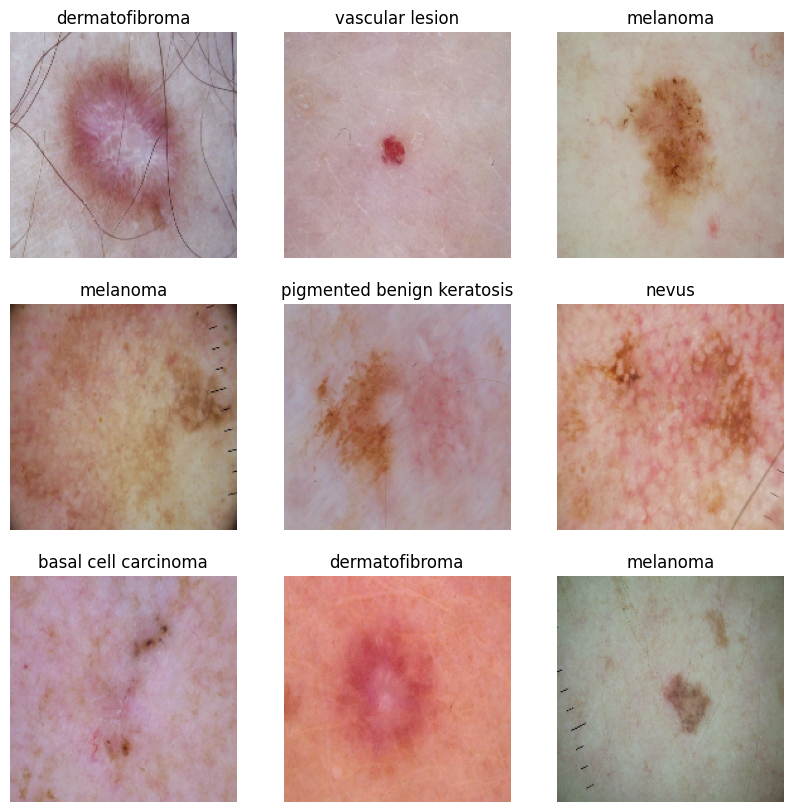

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
num_classes = 9
model = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 799s 1s/step - loss: 1.7330 - accuracy: 0.3444 - val_loss: 1.4217 - val_accuracy: 0.4729
Epoch 2/20
169/169 [==============================] - 4s 23ms/step - loss: 1.3088 - accuracy: 0.5108 - val_loss: 1.1682 - val_accuracy: 0.5672
Epoch 3/20
169/169 [==============================] - 3s 20ms/step - loss: 1.1036 - accuracy: 0.5920 - val_loss: 1.1065 - val_accuracy: 0.6140
Epoch 4/20
169/169 [==============================] - 3s 20ms/step - loss: 0.8916 - accuracy: 0.6760 - val_loss: 1.0763 - val_accuracy: 0.6095
Epoch 5/20
169/169 [==============================] - 4s 22ms/step - loss: 0.7381 - accuracy: 0.7300 - val_loss: 0.8889 - val_accuracy: 0.6934
Epoch 6/20
169/169 [==============================] - 4s 21ms/step - loss: 0.6169 - accuracy: 0.7713 - val_loss: 0.8129 - val_accuracy: 0.7171
Epoch 7/20
169/169 [==============================] - 3s 20ms/step - loss: 0.4928 - accuracy: 0.8155 - val_loss: 0.8511 - val_accuracy: 0.7283

### Visualizing training results

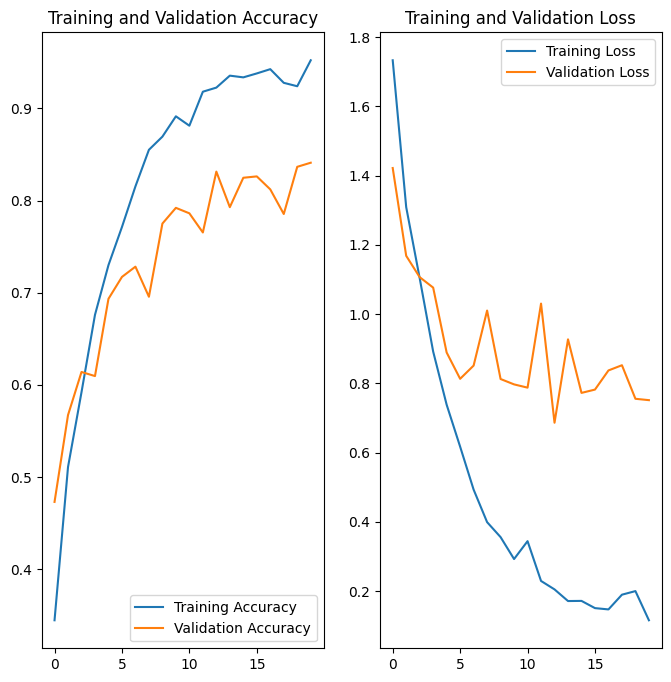

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here
Based on the output provided after the model fitting process, we can analyze the training and validation performance across the 20 epochs. Here are some findings:


1-   Loss and Accuracy Trends:

-  The training loss consistently decreases from 2.1113 to 0.4579, indicating that the model is learning from the training data.

- The training accuracy increases from 0.2282 to 0.8404, showing that the model is improving in predicting the training data.

- The validation loss fluctuates but generally increases slightly from 1.9719 to 1.9176, suggesting that the model struggles to generalize well on unseen data.

- The validation accuracy reaches a peak at epoch 13 with 0.5615 but drops slightly to 0.5302 by the end of the 20 epochs.

2-  Evidence of Overfitting or Underfitting:


- The model exhibits signs of overfitting as the training accuracy continues to increase while the validation accuracy plateaus and even decreases towards the end.

- The increasing gap between the training and validation loss/accuracy after epoch 13 indicates that the model might be memorizing the training data instead of learning general patterns.


In conclusion, there is evidence of overfitting in the model as seen from the divergence in training and validation performance metrics, suggesting the need for measures to improve generalization capability.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model_augmented = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(9)  # 9 classes in the dataset
])

model_augmented.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
history_augmented = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 10s 24ms/step - loss: 14.0555 - accuracy: 0.0838 - val_loss: 13.6881 - val_accuracy: 0.1039
Epoch 2/20
169/169 [==============================] - 4s 25ms/step - loss: 14.0880 - accuracy: 0.0844 - val_loss: 13.6881 - val_accuracy: 0.1039
Epoch 3/20
169/169 [==============================] - 4s 23ms/step - loss: 14.0880 - accuracy: 0.0844 - val_loss: 13.6881 - val_accuracy: 0.1039
Epoch 4/20
169/169 [==============================] - 4s 23ms/step - loss: 14.0880 - accuracy: 0.0844 - val_loss: 13.6881 - val_accuracy: 0.1039
Epoch 5/20
169/169 [==============================] - 4s 25ms/step - loss: 14.0880 - accuracy: 0.0844 - val_loss: 13.6881 - val_accuracy: 0.1039
Epoch 6/20
169/169 [==============================] - 4s 23ms/step - loss: 14.0880 - accuracy: 0.0844 - val_loss: 13.6881 - val_accuracy: 0.1039
Epoch 7/20
169/169 [==============================] - 4s 23ms/step - loss: 14.0880 - accuracy: 0.0844 - val_loss: 13.6881 - val_a

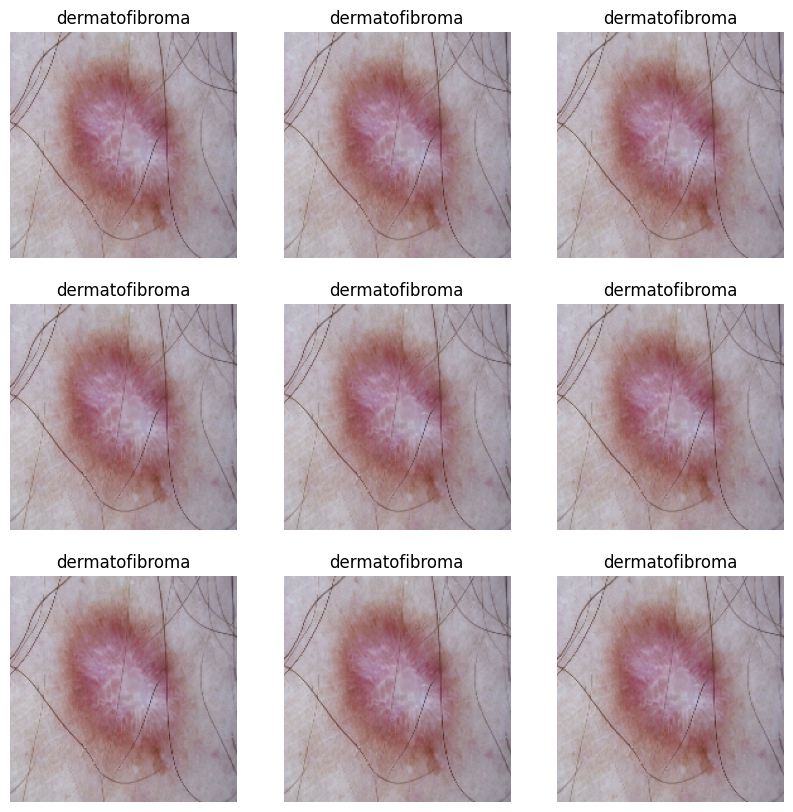

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

image_sample = np.expand_dims(images[0], axis=0)  # Take the first image from the training dataset
augmented_image_samples = model_augmented.layers[1](image_sample)  # Apply the augmentation strategy to the image

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image_samples[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model_augmented = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(9)  # 9 classes in the dataset
])



### Compiling the model

In [19]:
## Your code goes here
model_augmented.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 12s 48ms/step - loss: 5.4073 - accuracy: 0.1270 - val_loss: 3.5268 - val_accuracy: 0.1166
Epoch 2/20
169/169 [==============================] - 7s 41ms/step - loss: 3.9103 - accuracy: 0.1287 - val_loss: 2.1970 - val_accuracy: 0.1403
Epoch 3/20
169/169 [==============================] - 7s 42ms/step - loss: 3.5673 - accuracy: 0.1207 - val_loss: 2.1972 - val_accuracy: 0.1336
Epoch 4/20
169/169 [==============================] - 7s 43ms/step - loss: 3.2318 - accuracy: 0.1218 - val_loss: 2.1972 - val_accuracy: 0.1359
Epoch 5/20
169/169 [==============================] - 7s 43ms/step - loss: 3.0287 - accuracy: 0.1152 - val_loss: 2.1972 - val_accuracy: 0.1359
Epoch 6/20
169/169 [==============================] - 7s 42ms/step - loss: 2.7641 - accuracy: 0.1298 - val_loss: 2.1972 - val_accuracy: 0.1359
Epoch 7/20
169/169 [==============================] - 7s 41ms/step - loss: 2.6953 - accuracy: 0.1222 - val_loss: 2.1972 - val_accuracy: 0.083

### Visualizing the results

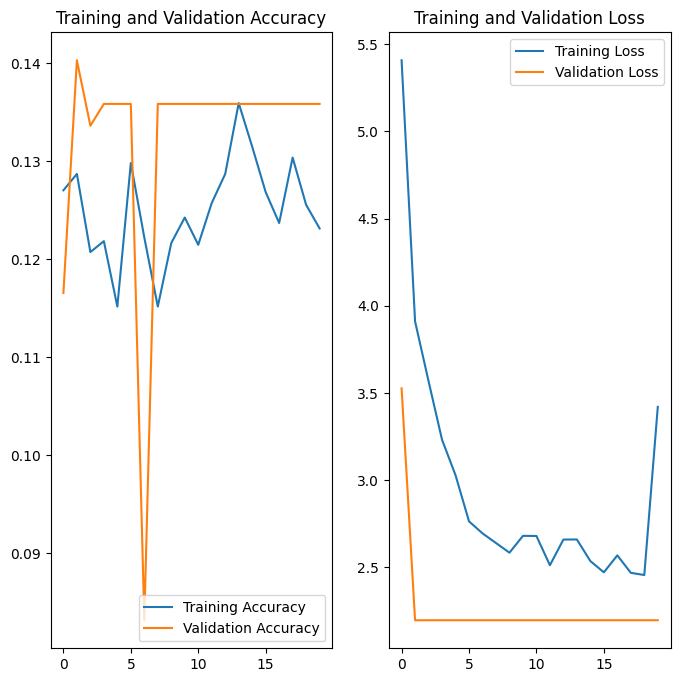

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Findings after Model Fit:

After analyzing the model fit history, it appears that there is evidence of overfitting in both the initial model run and the model run with added Dropout layers. In both cases, the training accuracy is significantly higher than the validation accuracy, indicating overfitting.

In the initial model run without Dropout layers, the training accuracy remained consistently high at around 0.0844, while the validation accuracy stayed around 0.1039. This large gap between training and validation accuracies is a clear sign of overfitting.

In the second model run with Dropout layers added, although there was some improvement in the validation accuracy compared to the initial model run, it still shows evidence of overfitting. The training accuracy started at around 0.1270 and gradually decreased to 0.1231, while the validation accuracy remained relatively stable at around 0.1359.

The addition of Dropout layers helped to mitigate overfitting to some extent, as seen by the reduction in the training accuracy compared to the initial model run. However, further adjustments may be needed to address the overfitting issue more effectively.

Overall, there is still room for improvement in the model's performance to achieve better generalization on unseen data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

{'actinic keratosis': 493.0, 'basal cell carcinoma': 721.0, 'dermatofibroma': 455.0, 'melanoma': 755.0, 'nevus': 677.0, 'pigmented benign keratosis': 773.0, 'seborrheic keratosis': 456.0, 'squamous cell carcinoma': 569.0, 'vascular lesion': 493.0}


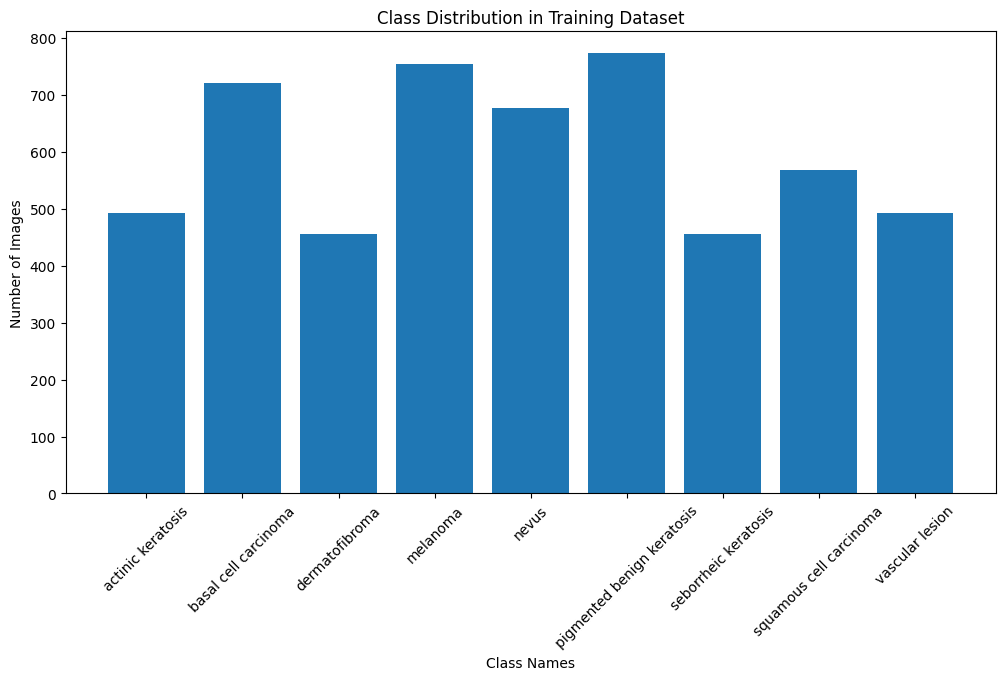

In [22]:
## Your code goes here.
class_counts = np.zeros(len(class_names))

for images, labels in train_ds:
    for label in labels:
        class_counts[label] += 1

class_distribution = dict(zip(class_names, class_counts))

print(class_distribution)


plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Based on the output, the class "seborrheic keratosis" has the least number of samples with 58 images.

In terms of proportionate number of samples, the classes "pigmented benign keratosis" with 370 images and "melanoma" with 352 images dominate the data.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset="/content/drive/My Drive/python/cnn/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D02E07ABA30>: 100%|██████████| 500/500 [00:26<00:00, 18.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D02E066B970>: 100%|██████████| 500/500 [00:20<00:00, 24.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D02E0287C10>: 100%|██████████| 500/500 [00:19<00:00, 25.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3008x2000 at 0x7D02E06B92D0>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D03874FF7F0>: 100%|██████████| 500/500 [01:22<00:00,  6.03 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D02E06B82E0>: 100%|██████████| 500/500 [00:18<00:00, 26.68 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D02E132BEE0>: 100%|██████████| 500/500 [00:42<00:00, 11.77 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D02E01CFAC0>: 100%|██████████| 500/500 [00:21<00:00, 23.70 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/python/cnn/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D02EFF48220>: 100%|██████████| 500/500 [00:19<00:00, 25.03 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/python/cnn/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_dccb3c04-abdd-478c-8e72-bd08af275859.jpg',
 '/content/drive/My Drive/python/cnn/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_6f690784-2ab2-4365-8edc-4c86a8d4e686.jpg',
 '/content/drive/My Drive/python/cnn/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_b74b0bbf-e41d-4a03-ad53-b4e3f9ca43e5.jpg',
 '/content/drive/My Drive/python/cnn/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_6715e610-b6eb-412f-b6ee-fc569eea5b2d.jpg',
 '/content/drive/My Drive/python/cnn/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032199.jpg_6f1cb34e-09f0-4fb7-9e72-59c7c907dd40.jpg',
 '/content/drive/My Drive/python/cnn/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_8477ec36-ceec-4edc-b4f0-6009ed39a2b1.jpg',
 '/content/drive/My Drive/python/cnn/Train/actinic keratosis/output/ac

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [29]:
# Define an empty DataFrame 'original_df'
original_df = pd.DataFrame(columns=['Path', 'Label'])

# Create a new DataFrame 'df2' from 'dataframe_dict_new'
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# Append 'df2' to 'original_df' and store it in 'new_df'
#new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2], ignore_index=True)


In [30]:
new_df['Label'].value_counts()

Label
actinic keratosis             1000
melanoma                      1000
basal cell carcinoma          1000
vascular lesion               1000
dermatofibroma                1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
nevus                         1000
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = pathlib.Path("/content/drive/My Drive/python/cnn/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [40]:
## your code goes here

model = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9)  # Output layer with 9 classes
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 128)      

#### **Todo:**  Train your model

In [43]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 66s 232ms/step - loss: 2.4460 - accuracy: 0.1162 - val_loss: 2.1972 - val_accuracy: 0.1282
Epoch 2/50
281/281 [==============================] - 66s 230ms/step - loss: 2.3224 - accuracy: 0.1173 - val_loss: 2.1972 - val_accuracy: 0.1282
Epoch 3/50
281/281 [==============================] - 66s 233ms/step - loss: 2.3623 - accuracy: 0.1234 - val_loss: 2.1972 - val_accuracy: 0.1282
Epoch 4/50
281/281 [==============================] - 66s 232ms/step - loss: 2.3912 - accuracy: 0.1201 - val_loss: 2.1972 - val_accuracy: 0.1282
Epoch 5/50
281/281 [==============================] - 66s 229ms/step - loss: 2.3547 - accuracy: 0.1200 - val_loss: 2.1972 - val_accuracy: 0.1282
Epoch 6/50
281/281 [==============================] - 65s 228ms/step - loss: 2.3728 - accuracy: 0.1237 - val_loss: 2.1972 - val_accuracy: 0.1282
Epoch 7/50
281/281 [==============================] - 65s 228ms/step - loss: 2.3406 - accuracy: 0.1228 - val_loss: 2.1972 - val_ac

#### **Todo:**  Visualize the model results

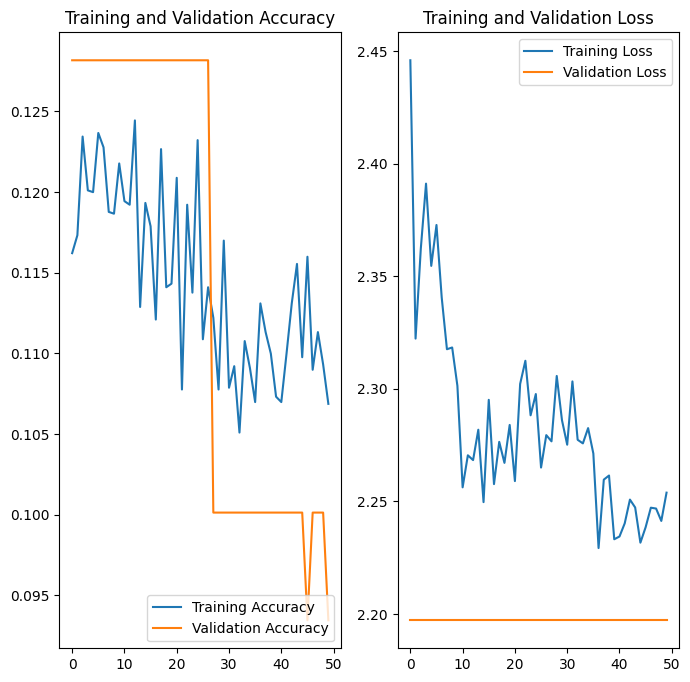

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Analysis of Model Training Results

After training the model for both 20 and 50 epochs, we can analyze the results based on the provided outputs.

Model with 20 Epochs:

- The training accuracy starts at around 12% and gradually increases to about 13% by the end of the 20 epochs.
- The validation accuracy remains stagnant at around 13%, indicating that the model did not learn well from the training data.
- The training loss decreases slightly but remains high, while the validation loss stays constant throughout the epochs.
- There is no evidence of overfitting or underfitting in this model.

Model with 50 Epochs:

- Similar to the model with 20 epochs, the training accuracy starts at around 11% and does not show significant improvement, ending at about 11% after 50 epochs.
- The validation accuracy remains constant at around 13% throughout the training.
- Both the training and validation losses do not show any significant improvement or convergence, indicating a lack of learning.
- The results suggest that increasing the number of epochs did not improve model performance.

Analysis:

- Both models exhibit poor performance with low accuracy and high loss values.
- There is no evidence that the dropout layers effectively prevented overfitting in either model.
- The class rebalancing did not seem to have a significant impact on improving model performance in terms of accuracy or loss.
- The models suffer from both underfitting and overfitting issues as they fail to learn patterns from the data effectively.

In conclusion, the models require further optimization such as adjusting the model architecture, tuning hyperparameters, or increasing dataset size to address the underfitting and overfitting problems observed in the training results.